## Import libraries

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from mlrefined_libraries import convnets_library as convlib
from mlrefined_libraries import basics_library as baslib
import autograd.numpy as np
import pandas as pd
import cv2
import csv
import pickle
import glob
import time

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## load data

In [2]:
 def load_data(csvname):
    # load in data
    data = np.asarray(pd.read_csv(csvname))

    # import data and reshape appropriately
    X = data[:,0:-1]
    y = data[:,-1]
    y.shape = (len(y),1)
    
    X_square = np.zeros((len(y),28,28))
    for i in range(0,len(y)):
        X_square[i,:,:] = np.reshape(X[i,:],(28,28),1)
    
    # pad data with ones for more compact gradient computation
    o = np.ones((np.shape(X)[0],1))
    X = np.concatenate((o,X),axis = 1)
    X = X.T
    
    return X,X_square,y

In [3]:
# load data
X,X_square, y = load_data('../../mlrefined_datasets/convnet_datasets/feat_face_data.csv')

<IPython.core.display.Javascript object>


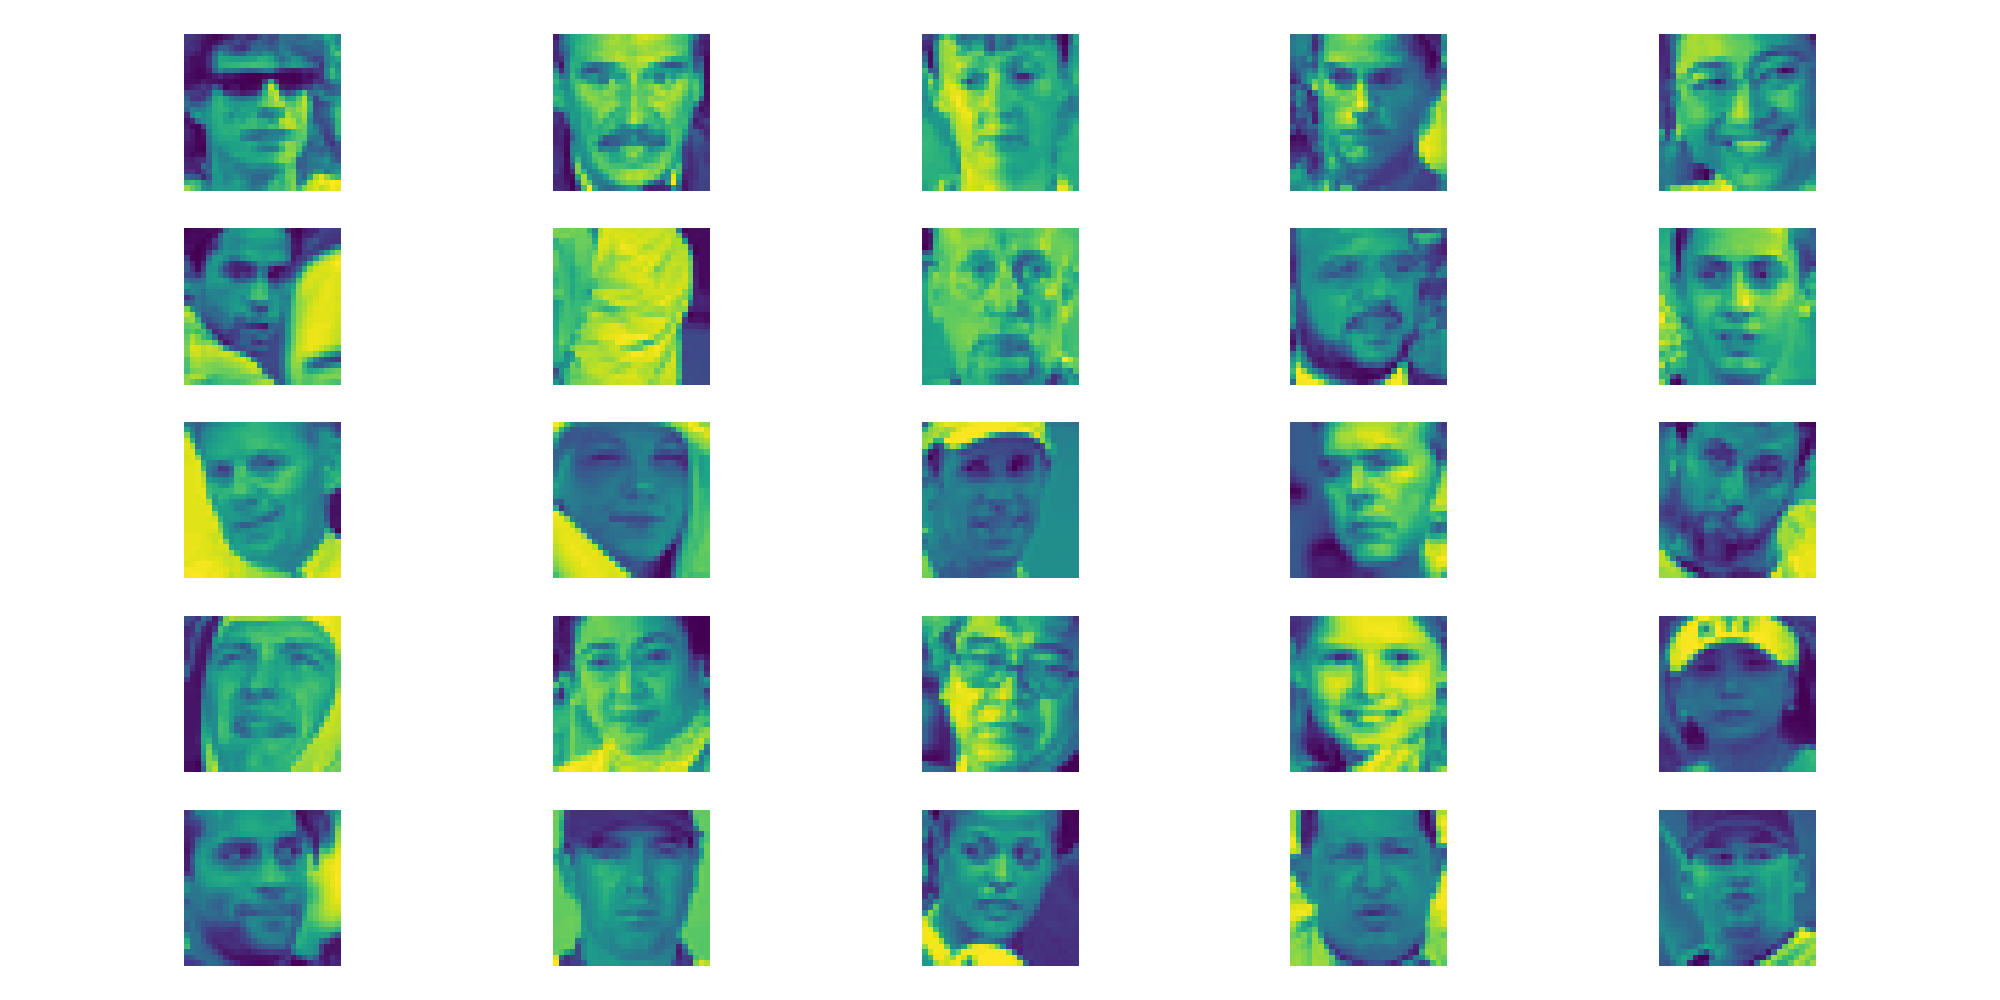

In [26]:
plt.figure(figsize=(10,5))
for i in range(1000,1025):
    plt.subplot(5,5,i+1-1000)
    plt.imshow(X_square[i,:,:])
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    plt.show()

<IPython.core.display.Javascript object>


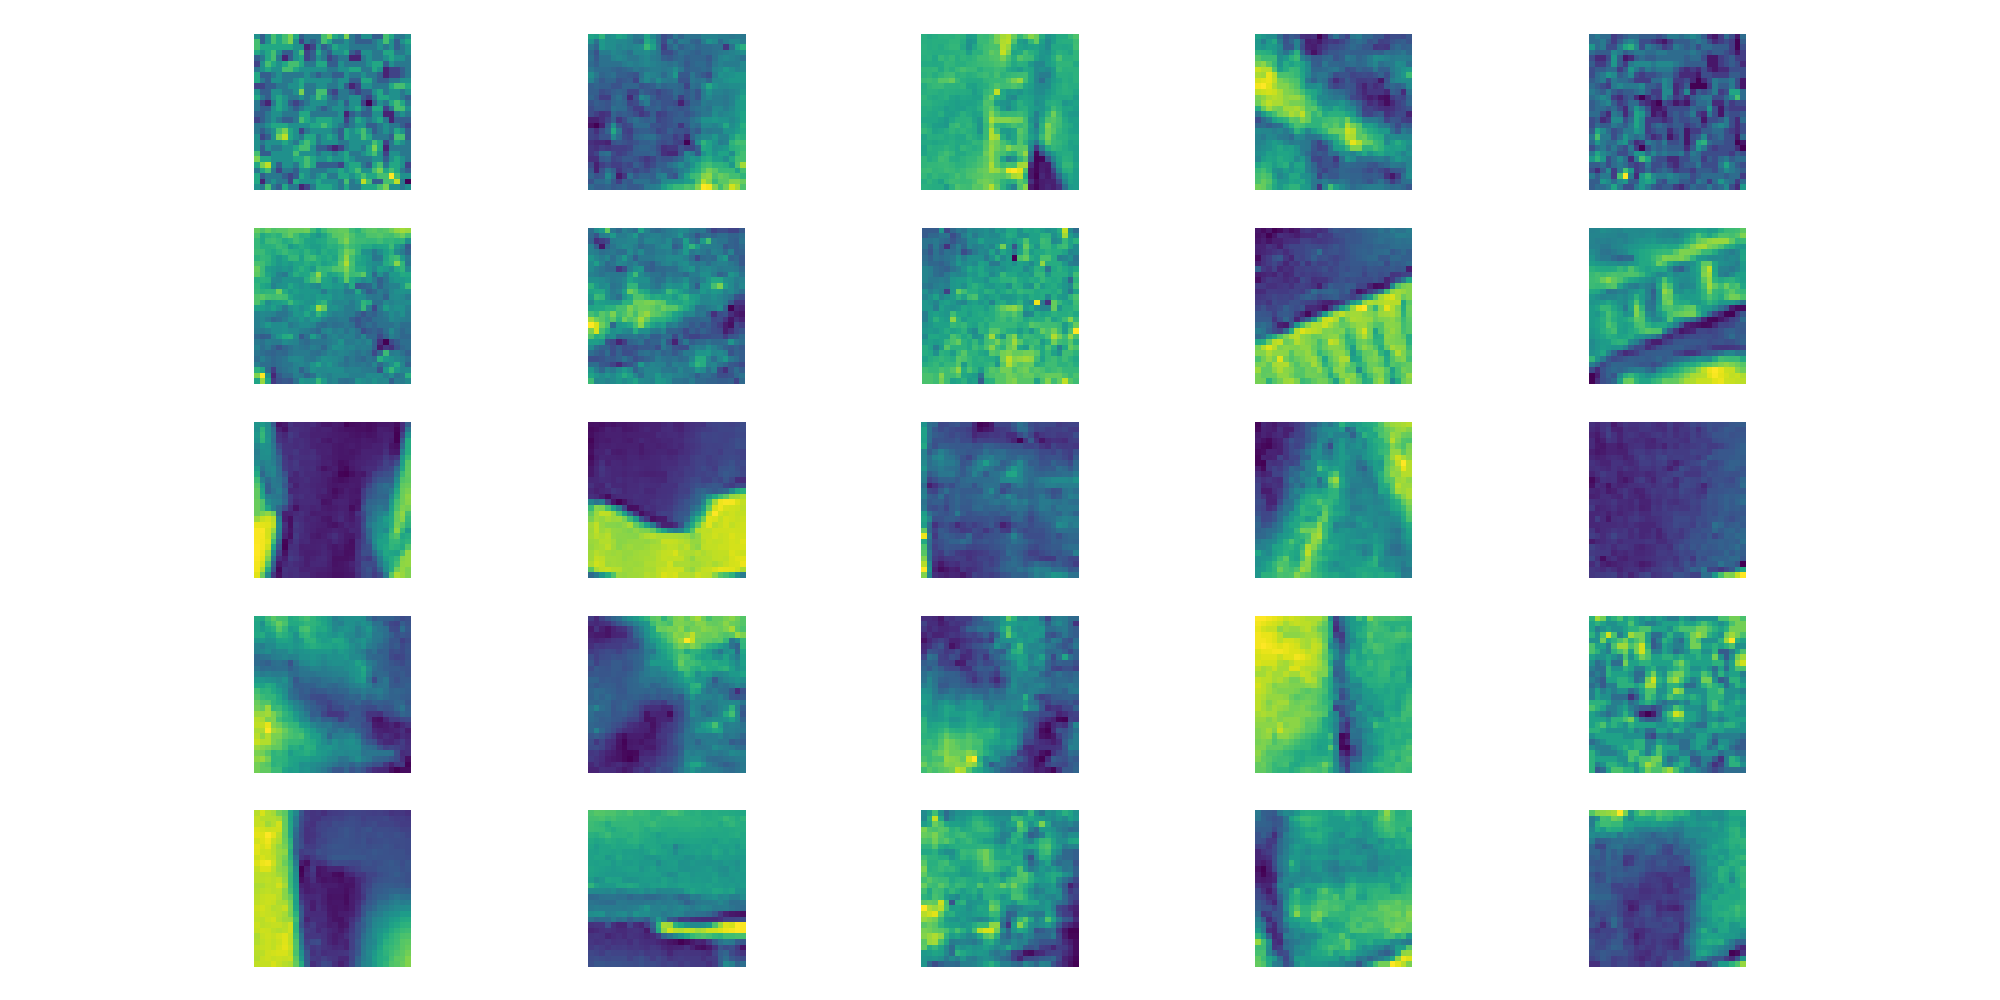

In [25]:
plt.figure(figsize=(10,5))
for i in range(9000,9025):
    plt.subplot(5,5,i+1-9000)
    plt.imshow(X_square[i,:,:])
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    plt.show()

## Extract features 

In [34]:
# create HOG-like features for data

# load kernels
kernels = convlib.image_viz.load_kernels()
#kernels = convlib.image_viz.load_kernels_v2(8,(3,3))

# params
sliding_window_size= (5,5) 
stride=3
pooling_func= 'max'
norm = 'max'

# get number of images in the dataset
num_images = np.shape(X_square)[0]

# create HOG descriptor
hog_desc = cv2.HOGDescriptor()
        
# a test run to find the number of features with the params above
test = convlib.image_viz.make_feat(X_square[0,:,:], kernels, sliding_window_size=sliding_window_size, stride=stride)
num_features = np.shape(test)[0]

                
feat = np.zeros((num_features,num_images))
hog = np.zeros((num_features,num_images))
for i in range(0,num_images):
    # extract my features
    feat[:,i] = convlib.image_viz.make_feat(X_square[i,:,:], kernels, sliding_window_size=sliding_window_size,
                                            stride=stride, pooling_func=pooling_func, norm=norm)
    # extract HOG features
    #hog[:,i] = hog_desc.compute(X_square[i,:,:])
    
# uncomment to pad features with ones (if needed)
feat = np.concatenate((np.ones((1,num_images)),feat))          

In [35]:
print('number of images: ', np.shape(y)[0])
print('number of raw pixels: ', np.shape(X)[0])
print('number of my features: ', np.shape(feat)[0])
#print('number of HOG features: ', np.shape(hog)[0])

number of images:  9999
number of raw pixels:  785
number of my features:  513


In [36]:
# split into train/test
X_train = np.concatenate((X[:,0:2000],X[:,2999:8000]),1)
feat_train = np.concatenate((feat[:,0:2000],feat[:,2999:8000]),1)
y_train = np.concatenate((y[0:2000],y[2999:8000]))

X_test = np.concatenate((X[:,2000:2999],X[:,8000:10000]),1)
feat_test = np.concatenate((feat[:,2000:2999],feat[:,8000:10000]),1)
y_test = np.concatenate((y[2000:2999],y[8000:10000]))

## Classification

In [30]:
###### for squared margin cost #######
# function for computing gradient and Hessian for squared margin cost Newton's method
def squared_margin_grad_hess(X, y, w):
    hess = 0
    grad = 0
    for p in range(0,len(y)):
        # precompute        
        x_p = X[:,p]
        y_p = y[p]
        
        # update grad and hessian
        grad+= -2*max(0,1 - y_p*np.dot(x_p.T,w))*y_p*x_p
        
        if 1 - y_p*np.dot(x_p.T,w) > 0:
            hess+= 2*np.outer(x_p,x_p)
        
    grad.shape = (len(grad),1)
    return grad,hess

# run newton's method
def squared_margin_newtons_method(X_train, y_train, w, X_test, y_test):
    # begin newton's method loop    
    max_its = 5
    misclass_history = []
    for k in range(max_its):
        # compute gradient and Hessian
        grad,hess = squared_margin_grad_hess(X_train, y_train, w)

        # take Newton step
        hess = hess + 10**-3*np.diag(np.ones((np.shape(X_train)[0])))
        temp = np.dot(hess,w) - grad        
        w = np.dot(np.linalg.pinv(hess),temp)

        # update history container
        cost = count_misclasses(w, X_test, y_test)
        misclass_history.append(cost)
        
        print('iteration:',k+1, ' of ', max_its)
    
    return misclass_history

In [31]:
# function for counting the number of misclassifications
def count_misclasses(w, X, y):
    y_pred = np.sign(np.dot(X.T,w))
    num_misclassed = len(y) - len([i for i, j in zip(y, y_pred) if i == j])
    return num_misclassed

In [20]:
###### raw pixels #######
w0 = np.random.randn(np.shape(X_train)[0],1)
squared_margin_history_raw = squared_margin_newtons_method(X_train, y_train, w0, X_test, y_test)

iteration: 1  of  5
iteration: 2  of  5
iteration: 3  of  5
iteration: 4  of  5
iteration: 5  of  5


In [37]:
###### HOG #######
w0 = np.random.randn(np.shape(feat)[0],1)
squared_margin_history_HOG = squared_margin_newtons_method(feat_train, y_train, w0, feat_test, y_test)

iteration: 1  of  5
iteration: 2  of  5
iteration: 3  of  5
iteration: 4  of  5
iteration: 5  of  5


<IPython.core.display.Javascript object>


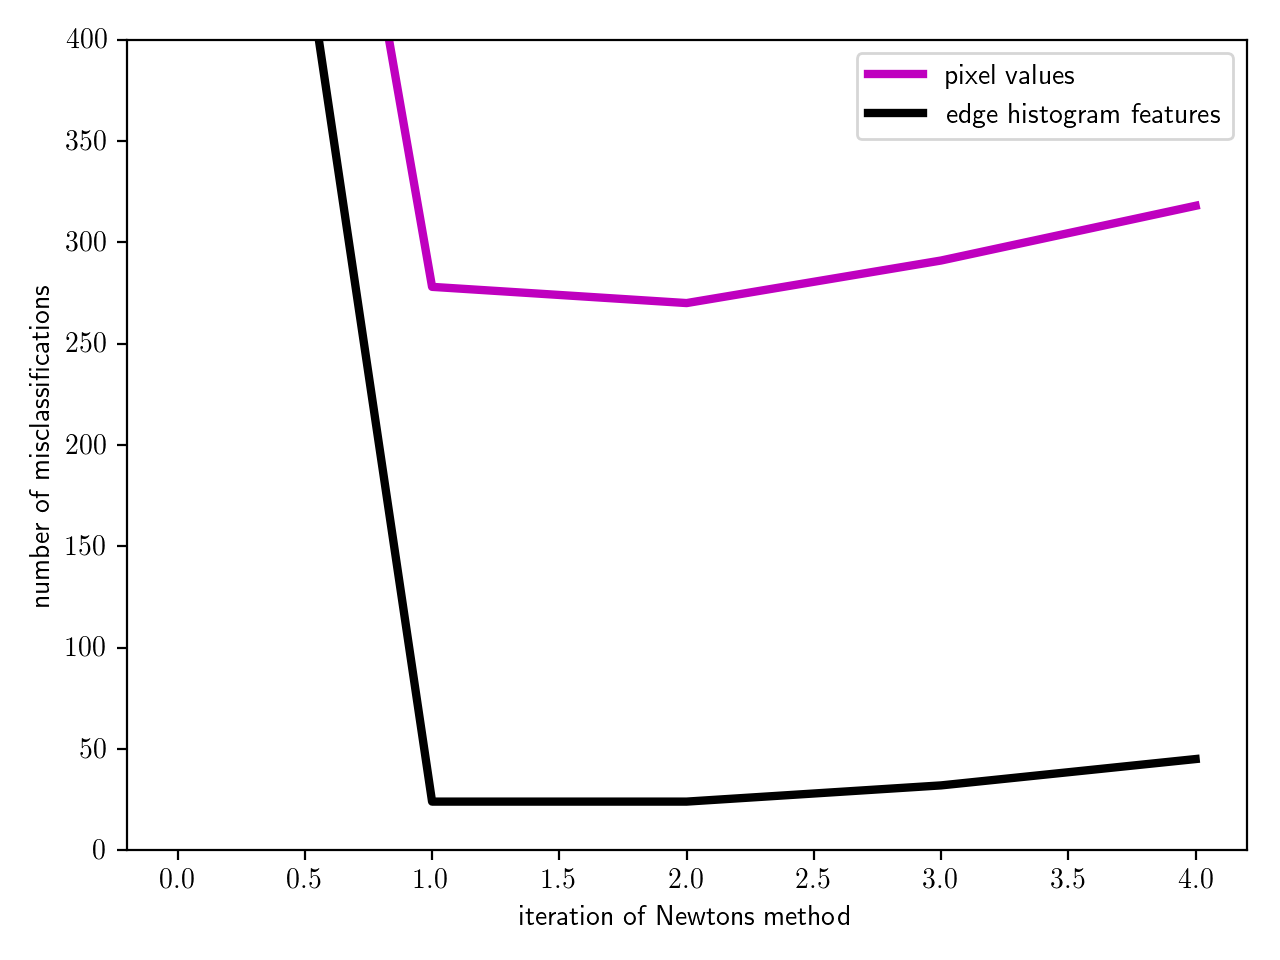

In [38]:
plt.figure()
# plot results
plt.plot(squared_margin_history_raw,color = 'm', linewidth=3)
plt.plot(squared_margin_history_HOG,'k', linewidth=3)

# clean up plot
plt.ylim([0,400])
plt.xlabel('iteration of Newtons method')
plt.ylabel('number of misclassifications')
plt.legend(['pixel values','edge histogram features'])
plt.show()